# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
from prettytable import PrettyTable
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score,roc_auc_score,auc,roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [241]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [242]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [243]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [244]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [245]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [246]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
We have a 15-year old arthritic Siberian Husky.  We had tried over-the-counter glucosamine for him, but it did nothing.  A vet then told us most pills sold over-the-counter are poor quality and do not sufficiently digest and enter the bloodstream...for humans or dogs.  We later tried Zuke's Hip Action, and definitely saw a difference.  We have been using them for several years now.  Our dog's arthritis progressed, so he's now on prescription meds and senior dog food (which also has gulcosamine), but he's doing great...running up and down stairs, playing.  People think he's a puppy!  He quickly tired of the beef flavor Hip Action, but still loves the peanut butter flavor.  We'll continue using this product as long as we have our dog.
Bigelow isn't the cheapest tea around, but they are the best tasting (Altho I like Twini

In [10]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [11]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
We have a 15-year old arthritic Siberian Husky.  We had tried over-the-counter glucosamine for him, but it did nothing.  A vet then told us most pills sold over-the-counter are poor quality and do not sufficiently digest and enter the bloodstream...for humans or dogs.  We later tried Zuke's Hip Action, and definitely saw a difference.  We have been using them for several years now.  Our dog's arthritis progressed, so he's now on prescription meds and senior dog food (which also has gulcosamine), but he's doing great...running up and down stairs, playing.  People think he's a puppy!  He quickly tired of the beef flavor Hip Action, but still loves the peanut butter flavor.  We'll continue using this product as long as we have our dog.
Bigelow isn't the cheapest tea around, but they are the best tasting (Altho I like Twini

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Bigelow is not the cheapest tea around, but they are the best tasting (Altho I like Twinings' Earl Grey blend better than Bigelow is). Foil packs keep them fresh tasting pretty much forever. Lemon Lift is hint of spicy lemon is always a hit with company, and has won over many coffee drinkers. Also great, and hard to find in stores, is Bigelow is Chinese Fortune. Plantation mint, for spearmint lovers, is great in the Summer months. I know this sounds like a commercial, but Bigelow deserves it!


In [14]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Bigelow is not the cheapest tea around but they are the best tasting Altho I like Twinings Earl Grey blend better than Bigelow is Foil packs keep them fresh tasting pretty much forever Lemon Lift is hint of spicy lemon is always a hit with company and has won over many coffee drinkers Also great and hard to find in stores is Bigelow is Chinese Fortune Plantation mint for spearmint lovers is great in the Summer months I know this sounds like a commercial but Bigelow deserves it 


In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [247]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████| 4986/4986 [00:05<00:00, 881.18it/s]


In [248]:
preprocessed_reviews[1500]

'usually pineapple coconut drinks drink not taste great taste not resemble anything close pina colada flavor actually difficult taste pineapple coconut tastes tangy little sour like water bit sugar sour ness yeah not really taste crave not sure everyone reaction drink not appeal really wanted like though said usually love pineapple coconut drinks'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [249]:
## Similartly you can do preprocessing for review summary also.

X_train=preprocessed_reviews
#X_test=preprocessed_reviews[33917:]

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [190]:
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
bow_fnames=count_vect.get_feature_names()
final_counts_train = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46072, 39365)
the number of unique words  39365


In [191]:
pre_mod=MaxAbsScaler().fit(final_counts_train)
std_bow_train=pre_mod.transform(final_counts_train)
print(std_bow_train.shape)

(46072, 39365)


In [38]:
iner=[]
for n_clu in range(2,11):
    print('Running clustering with K=',n_clu)
    lr=KMeans(n_clusters=n_clu,random_state=42,n_jobs=-1)
    lr.fit(std_bow_train)
    iner.append(lr.inertia_)

Running clustering with K= 2
Running clustering with K= 3
Running clustering with K= 4
Running clustering with K= 5
Running clustering with K= 6
Running clustering with K= 7
Running clustering with K= 8
Running clustering with K= 9
Running clustering with K= 10


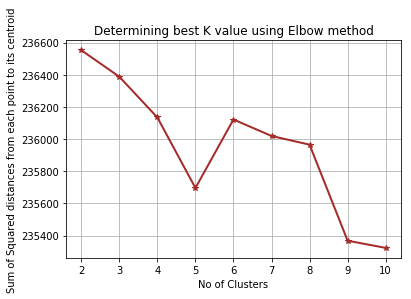

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(range(2,11),iner,marker='*',color='brown',linewidth=2)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Squared distances from each point to its centroid')
plt.title('Determining best K value using Elbow method')
plt.gca().set_facecolor('xkcd:white')
plt.grid() 
fig = plt.figure()

In [192]:
best_lr=KMeans(n_clusters=5,random_state=42,n_jobs=-1)
best_lr.fit(std_bow_train)
labels=best_lr.labels_

In [193]:
print('Inertia of best clustering on Bag of words data is - ',best_lr.inertia_)

Inertia of best clustering on Bag of words data is -  228593.21997635244


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [214]:
#With reference of -- https://pythonprogramminglanguage.com/kmeans-text-clustering/
from wordcloud  import WordCloud
#order_centroids = best_lr.cluster_centers_.argsort()[:, ::-1]
def word_cloud(i,labels):
    words=[]
    print("Cluster %d:" % i)
    words=[]
    un_words=[]
    fin_words=[]
    clust_dat=[]
    for ind in range(0,len(labels)):
        if(labels[ind]==i):
            clust_dat.append(X_train[ind].split())
    for j in range(0,len(clust_dat)):
        words=words+clust_dat[j]
    un_words=set(words)
    fin_words=' '.join(words)
    wordcloud = WordCloud(width=800, height=400,background_color='white').generate(fin_words)

    # Display the generated image:
    #plt.figure( figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Cluster 0:


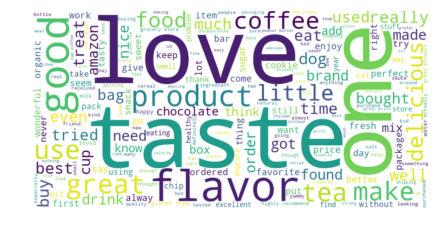

Cluster 1:


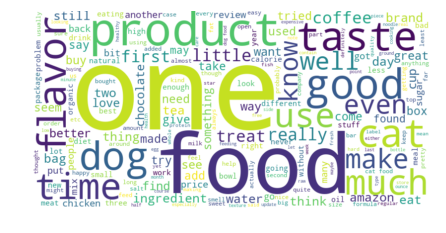

In [215]:
word_cloud(0,labels)
word_cloud(1,labels)

Cluster 2:


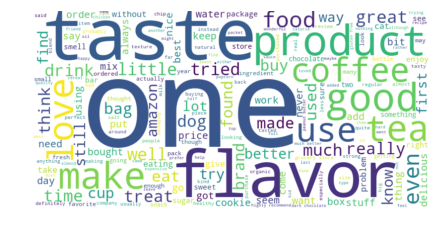

Cluster 3:


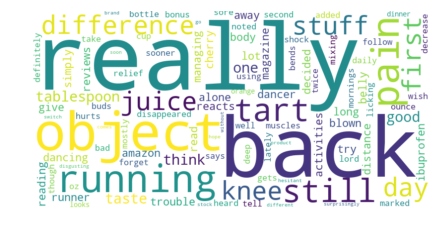

Cluster 4:


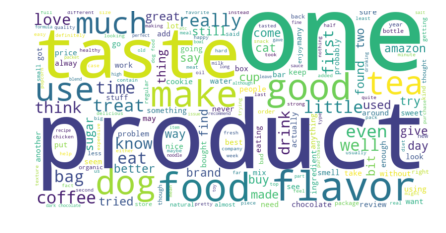

In [216]:
word_cloud(2,labels)
word_cloud(3,labels)
word_cloud(4,labels)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [217]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
tf_fnames=tf_idf_vect.get_feature_names()
final_tf_idf_train = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46072, 27313)
the number of unique words including both unigrams and bigrams  27313


In [218]:
pre_mod=MaxAbsScaler().fit(final_tf_idf_train)
std_tfidf_train=pre_mod.transform(final_tf_idf_train)
print(std_tfidf_train.shape)

(46072, 27313)


In [47]:
iner=[]
for n_clu in range(2,11):
    print('Running clustering with K=',n_clu)
    lr=KMeans(n_clusters=n_clu,random_state=42,n_jobs=-1)
    lr.fit(std_tfidf_train)
    iner.append(lr.inertia_)

Running clustering with K= 2
Running clustering with K= 3
Running clustering with K= 4
Running clustering with K= 5
Running clustering with K= 6
Running clustering with K= 7
Running clustering with K= 8
Running clustering with K= 9
Running clustering with K= 10


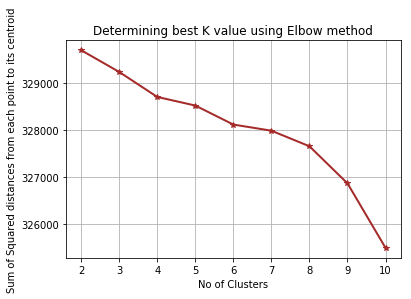

<Figure size 432x288 with 0 Axes>

In [48]:
plt.plot(range(2,11),iner,marker='*',color='brown',linewidth=2)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Squared distances from each point to its centroid')
plt.title('Determining best K value using Elbow method')
plt.gca().set_facecolor('xkcd:white')
plt.grid() 
fig = plt.figure()

In [219]:
best_lr=KMeans(n_clusters=10,random_state=42,n_jobs=-1)
best_lr.fit(std_tfidf_train)
labels=best_lr.labels_

In [220]:
print('Inertia of best clustering on Bag of words data is - ',best_lr.inertia_)

Inertia of best clustering on Bag of words data is -  309340.10263566254


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

Cluster 0:


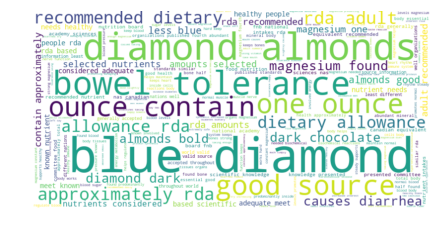

Cluster 1:


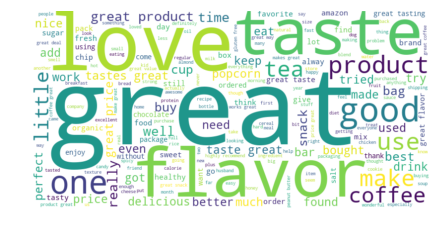

Cluster 2:


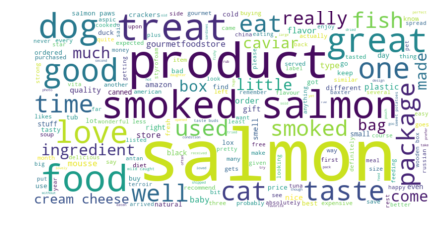

In [221]:
word_cloud(0,labels)
word_cloud(1,labels)
word_cloud(2,labels)

Cluster 3:


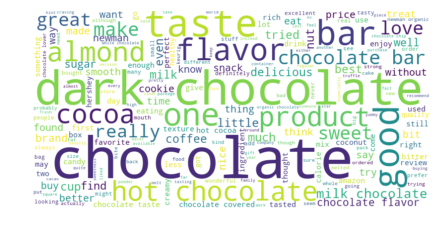

Cluster 4:


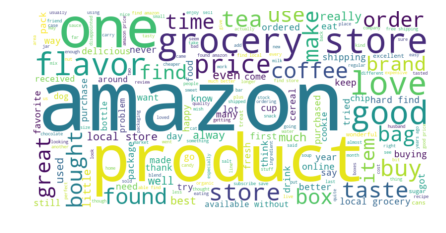

Cluster 5:


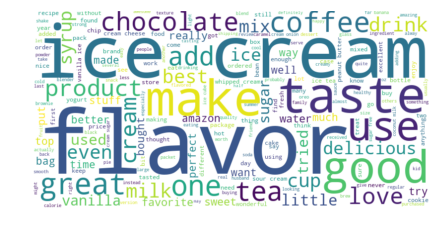

In [222]:
word_cloud(3,labels)
word_cloud(4,labels)
word_cloud(5,labels)

Cluster 6:


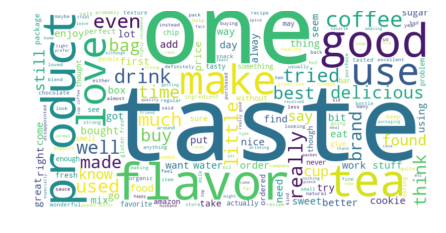

Cluster 7:


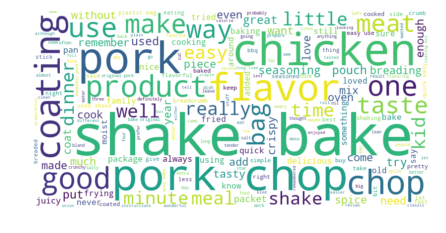

Cluster 8:


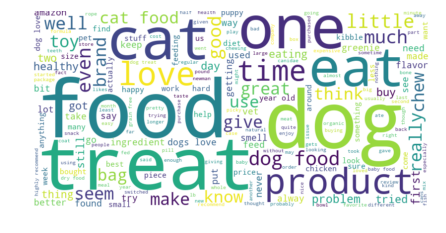

In [223]:
word_cloud(6,labels)
word_cloud(7,labels)
word_cloud(8,labels)

Cluster 9:


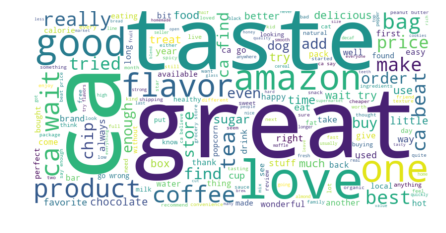

In [224]:
word_cloud(9,labels)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [225]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [226]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))

[('awesome', 0.8586353063583374), ('fantastic', 0.8068675398826599), ('terrific', 0.8067899346351624), ('excellent', 0.7946578860282898), ('good', 0.7894131541252136), ('wonderful', 0.7833511233329773), ('perfect', 0.7644174098968506), ('amazing', 0.7639861106872559), ('decent', 0.7013376951217651), ('nice', 0.6907120943069458)]
[('best', 0.7259860634803772), ('nastiest', 0.7132738828659058), ('greatest', 0.6710928678512573), ('experienced', 0.65867018699646), ('awful', 0.6345417499542236), ('hottest', 0.6226989030838013), ('tastiest', 0.6219632625579834), ('horrible', 0.6176090836524963), ('closest', 0.6139567494392395), ('displeasure', 0.6061538457870483)]


In [227]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  12798
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'screens', 'computer', 'stuff', 'sugar', 'free', 'not', 'rot']


In [228]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 46072/46072 [04:16<00:00, 179.84it/s]


46072
50


In [229]:
pre_mod=MaxAbsScaler().fit(sent_vectors_train)
std_aw2v_train=pre_mod.transform(sent_vectors_train)
print(std_aw2v_train.shape)

(46072, 50)


In [61]:
iner=[]
for n_clu in range(2,11):
    print('Running clustering with K=',n_clu)
    lr=KMeans(n_clusters=n_clu,random_state=42,n_jobs=-1)
    lr.fit(std_aw2v_train)
    iner.append(lr.inertia_)

Running clustering with K= 2
Running clustering with K= 3
Running clustering with K= 4
Running clustering with K= 5
Running clustering with K= 6
Running clustering with K= 7
Running clustering with K= 8
Running clustering with K= 9
Running clustering with K= 10


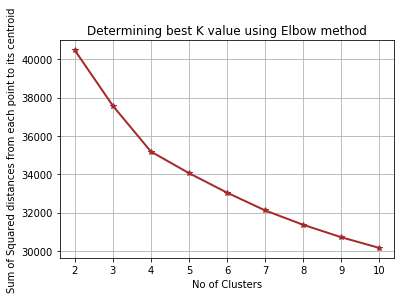

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(range(2,11),iner,marker='*',color='brown',linewidth=2)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Squared distances from each point to its centroid')
plt.title('Determining best K value using Elbow method')
plt.gca().set_facecolor('xkcd:white')
plt.grid() 
fig = plt.figure()

In [230]:
best_lr=KMeans(n_clusters=4,random_state=42,n_jobs=-1)
best_lr.fit(std_aw2v_train)
labels=best_lr.labels_

In [231]:
print('Inertia of best clustering on Bag of words data is - ',best_lr.inertia_)

Inertia of best clustering on Bag of words data is -  31585.625277983152


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

Cluster 0:


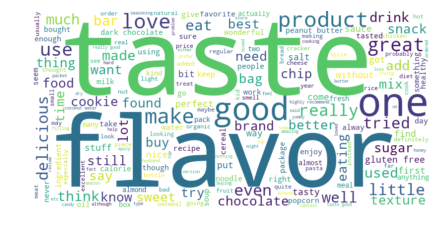

Cluster 1:


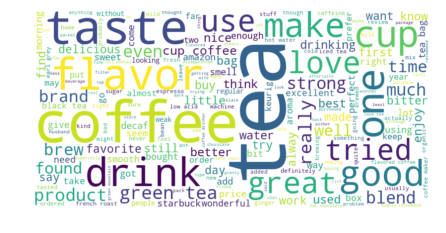

In [232]:
word_cloud(0,labels)
word_cloud(1,labels)

Cluster 2:


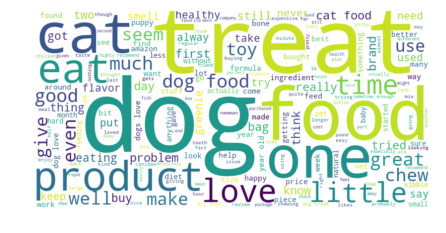

Cluster 3:


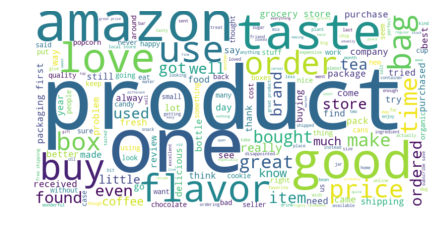

In [233]:
word_cloud(2,labels)
word_cloud(3,labels)

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [234]:
# Please write all the code with proper documentation
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [235]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 46072/46072 [44:31<00:00, 24.04it/s]


In [236]:
pre_mod=MaxAbsScaler().fit(tfidf_sent_vectors_train)
std_taw2v_train=pre_mod.transform(tfidf_sent_vectors_train)
print(std_taw2v_train.shape)

(46072, 50)


In [71]:
iner=[]
for n_clu in range(2,11):
    print('Running clustering with K=',n_clu)
    lr=KMeans(n_clusters=n_clu,random_state=42,n_jobs=-1)
    lr.fit(std_taw2v_train)
    iner.append(lr.inertia_)

Running clustering with K= 2
Running clustering with K= 3
Running clustering with K= 4
Running clustering with K= 5
Running clustering with K= 6
Running clustering with K= 7
Running clustering with K= 8
Running clustering with K= 9
Running clustering with K= 10


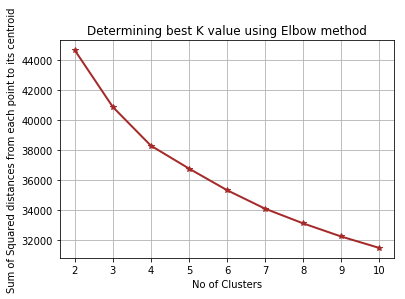

<Figure size 432x288 with 0 Axes>

In [72]:
plt.plot(range(2,11),iner,marker='*',color='brown',linewidth=2)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Squared distances from each point to its centroid')
plt.title('Determining best K value using Elbow method')
plt.gca().set_facecolor('xkcd:white')
plt.grid() 
fig = plt.figure()

In [237]:
best_lr=KMeans(n_clusters=4,random_state=42,n_jobs=-1)
best_lr.fit(std_taw2v_train)
labels=best_lr.labels_

In [238]:
print('Inertia of best clustering on Bag of words data is - ',best_lr.inertia_)

Inertia of best clustering on Bag of words data is -  37885.968219852126


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

Cluster 0:


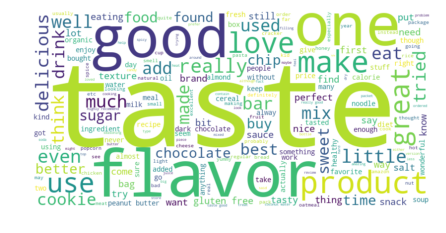

Cluster 1:


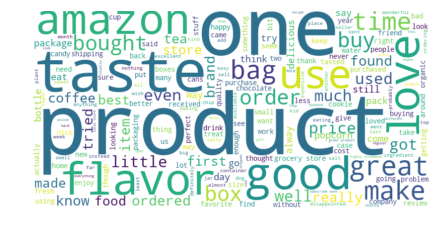

In [239]:
order_centroids = best_lr.cluster_centers_.argsort()[:, ::-1]
word_cloud(0,labels)
word_cloud(1,labels)

Cluster 2:


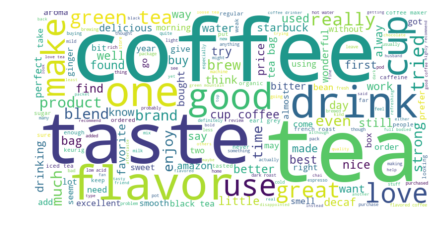

Cluster 3:


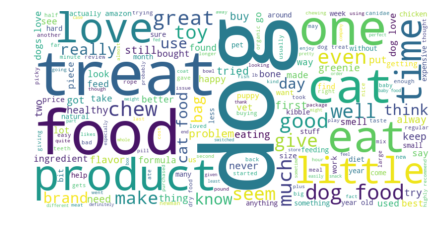

In [240]:
word_cloud(2,labels)
word_cloud(3,labels)

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [118]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [119]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))

[('yet', 0.9993380308151245), ('ok', 0.9993171691894531), ('similar', 0.9993056654930115), ('extremely', 0.9993055462837219), ('especially', 0.9992812275886536), ('everyone', 0.9992625713348389), ('consider', 0.9992576837539673), ('bits', 0.9992530345916748), ('people', 0.9992528557777405), ('overall', 0.9992426633834839)]
[('second', 0.9996356964111328), ('soup', 0.9996318221092224), ('packs', 0.9996075630187988), ('inside', 0.9995942711830139), ('mouth', 0.9995906949043274), ('instead', 0.9995769262313843), ('totally', 0.9995728731155396), ('nuts', 0.9995706081390381), ('quite', 0.9995685815811157), ('place', 0.9995632171630859)]


In [120]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  3003
sample words  ['really', 'good', 'idea', 'product', 'outstanding', 'use', 'car', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'computer', 'mae', 'ploy', 'sweet', 'chili', 'sauce', 'becoming', 'standard', 'condiment', 'dinner', 'table', 'right', 'blend', 'heat', 'taste', 'meat']


In [137]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = [];
lb_words=[]# the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    la_words=[]
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            la_words.append(word)
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    lb_words.append(la_words)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|█████████████████████████████████████| 3491/3491 [00:08<00:00, 408.19it/s]


3491
50


In [122]:
pre_mod=MaxAbsScaler().fit(sent_vectors_train)
std_aw2v_train=pre_mod.transform(sent_vectors_train)
print(std_aw2v_train.shape)

(3491, 50)


In [317]:
print('Running clustering with K= 5')
lr=AgglomerativeClustering(n_clusters=5)
lr.fit(std_aw2v_train)

Running clustering with K= 5


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [318]:
labels2=lr.labels_

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [319]:
# Please write all the code with proper documentation
def word_cloud_agg(n,labels2):
    print('Word clouds with features within each Clusters for K= ',n)
    for i in range(0,n):
        print("Cluster - ",i)
        words=[]
        un_words=[]
        fin_words=[]
        clust_dat=[]
        for ind in range(0,len(labels2)):
            if(labels2[ind]==i):
                clust_dat.append(lb_words[ind])
        print('No of records in cluster %d is %d'%(i,len(clust_dat)))
        for j in range(0,len(clust_dat)):
            words=words+lb_words[j]
        un_words=set(words)
        fin_words=' '.join(un_words)
        wordcloud = WordCloud(width=800, height=400,background_color='white').generate(fin_words)
        # Display the generated image:
        #plt.figure( figsize=(10,10), facecolor='k')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()

Word clouds with features within each Clusters for K=  5
Cluster -  0
No of records in cluster 0 is 2789


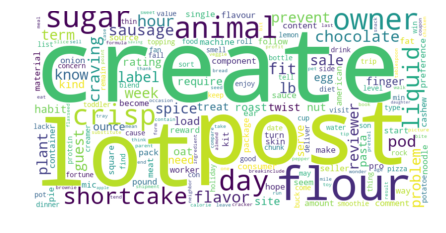

Cluster -  1
No of records in cluster 1 is 1200


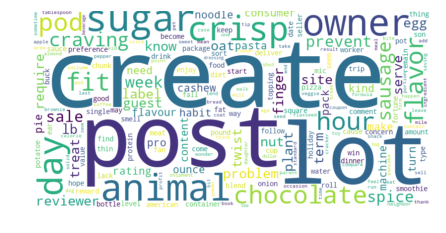

Cluster -  2
No of records in cluster 2 is 275


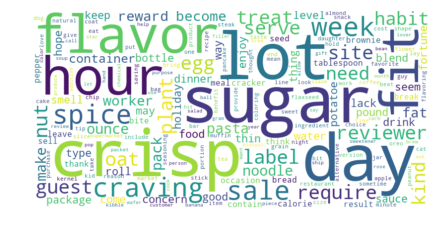

Cluster -  3
No of records in cluster 3 is 529


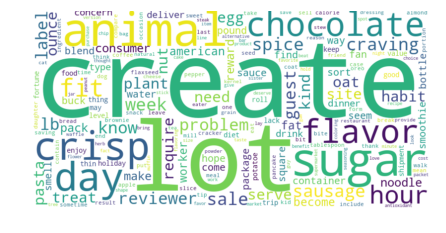

Cluster -  4
No of records in cluster 4 is 193


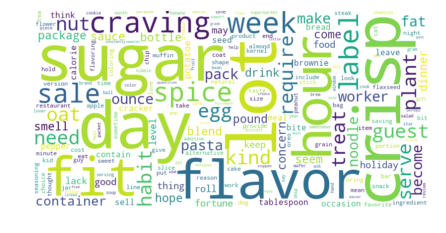

In [320]:
word_cloud_agg(5,labels2)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [175]:
# Please write all the code with proper documentation
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [176]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = [];
lb_words=[]# the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    la_words=[]
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            la_words.append(word)
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    lb_words.append(la_words)
    row += 1

100%|██████████████████████████████████████| 4986/4986 [01:17<00:00, 63.95it/s]


In [177]:
pre_mod=MaxAbsScaler().fit(tfidf_sent_vectors_train)
std_taw2v_train=pre_mod.transform(tfidf_sent_vectors_train)
print(std_taw2v_train.shape)

(4986, 50)


In [321]:
print('Running clustering with K= 5')
lr=AgglomerativeClustering(n_clusters=5)
lr.fit(std_taw2v_train)

Running clustering with K= 5


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [322]:
labels=lr.labels_

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Word clouds with features within each Clusters for K=  5
Cluster -  0
No of records in cluster 0 is 2867


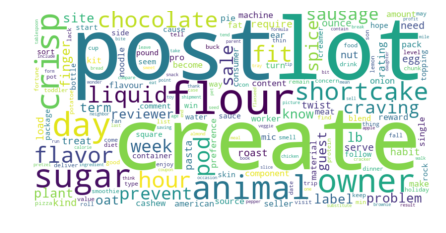

Cluster -  1
No of records in cluster 1 is 730


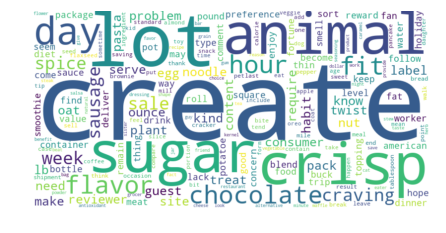

Cluster -  2
No of records in cluster 2 is 246


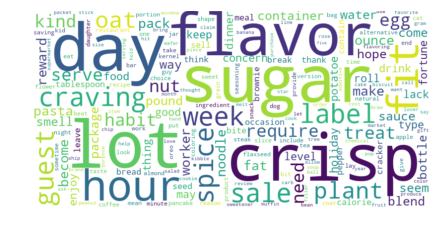

Cluster -  3
No of records in cluster 3 is 804


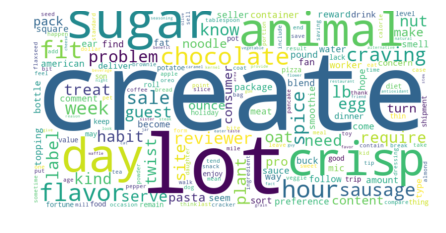

Cluster -  4
No of records in cluster 4 is 339


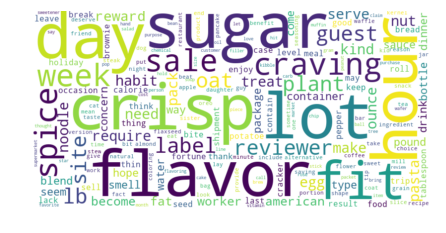

In [323]:
# Please write all the code with proper documentation
word_cloud_agg(5,labels)

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [250]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

[('alternative', 0.9939599633216858), ('backyard', 0.9936812520027161), ('ok', 0.99355149269104), ('snack', 0.9934977889060974), ('salted', 0.9934208393096924), ('overall', 0.993312656879425), ('crispy', 0.993248701095581), ('flavour', 0.9931612014770508), ('thai', 0.9931449294090271), ('crisp', 0.9931284189224243)]
[('extract', 0.9989938139915466), ('molasses', 0.998991847038269), ('jelly', 0.9989678263664246), ('together', 0.9989632368087769), ('tomato', 0.9989540576934814), ('awful', 0.9989475011825562), ('bland', 0.998927652835846), ('red', 0.9989230632781982), ('simply', 0.9989141821861267), ('enjoying', 0.998903751373291)]
number of words that occured minimum 5 times  3817
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'windows', 'bea

In [251]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = [];
lb_words=[]# the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    la_words=[]
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            la_words.append(word)
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    lb_words.append(la_words)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))


100%|█████████████████████████████████████| 4986/4986 [00:15<00:00, 312.23it/s]


4986
50


In [252]:
pre_mod=MaxAbsScaler().fit(sent_vectors_train)
std_aw2v_train=pre_mod.transform(sent_vectors_train)
print(std_aw2v_train.shape)

(4986, 50)


In [254]:
from sklearn.neighbors import NearestNeighbors
nn=NearestNeighbors(n_neighbors=200,n_jobs=-1)
nn_lr=nn.fit(std_aw2v_train)

In [310]:
dist,ind=nn.kneighbors(std_aw2v_train,n_neighbors=200,return_distance=True)

In [311]:
dist1=[]
for i in range(0,4986):
    dist1.append(dist[i,199])

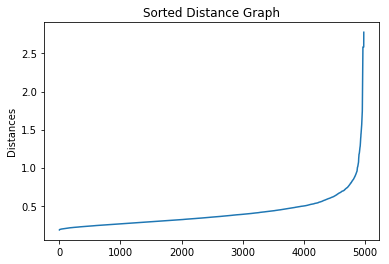

In [312]:
plt.figure()
plt.title("Sorted Distance Graph")
plt.ylabel("Distances")
plt.plot(np.arange(4986),sorted(dist1))
plt.show()

In [297]:
lr_db=DBSCAN(eps=0.7,min_samples=200,n_jobs=-1)
lr_db.fit(std_aw2v_train)

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=200, n_jobs=-1, p=None)

In [304]:
labels=lr_db.labels_
print(set(labels))
print('No. of clusters formed are : ',len(set(labels)))

{0, -1}
No. of clusters formed are :  2


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

Cluster -1:


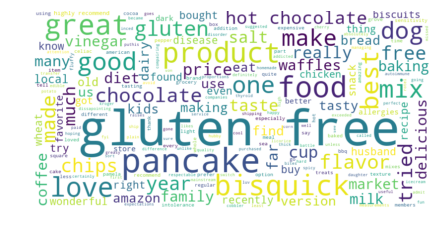

Cluster 0:


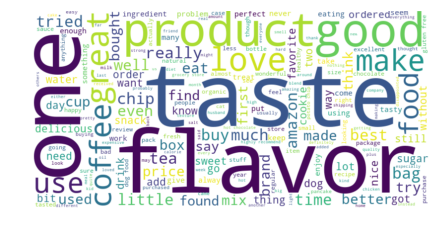

In [306]:
# Please write all the code with proper documentation
word_cloud(-1,labels)
word_cloud(0,labels)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [307]:
# Please write all the code with proper documentation
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [308]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = [];
lb_words=[]# the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    la_words=[]
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            la_words.append(word)
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    lb_words.append(la_words)
    row += 1

100%|██████████████████████████████████████| 4986/4986 [01:13<00:00, 67.42it/s]


In [309]:
pre_mod=MaxAbsScaler().fit(tfidf_sent_vectors_train)
std_taw2v_train=pre_mod.transform(tfidf_sent_vectors_train)
print(std_taw2v_train.shape)

(4986, 50)


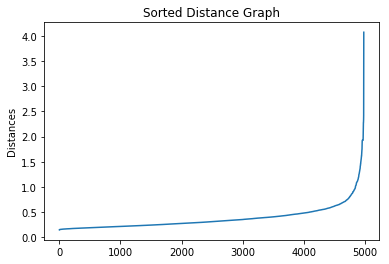

In [314]:
from sklearn.neighbors import NearestNeighbors
nn=NearestNeighbors(n_neighbors=200,n_jobs=-1)
nn_lr=nn.fit(std_taw2v_train)

dist,ind=nn.kneighbors(std_taw2v_train,n_neighbors=200,return_distance=True)

dist1=[]
for i in range(0,4986):
    dist1.append(dist[i,199])

plt.figure()
plt.title("Sorted Distance Graph")
plt.ylabel("Distances")
plt.plot(np.arange(4986),sorted(dist1))
plt.show()

In [315]:
lr_db=DBSCAN(eps=0.7,min_samples=200,n_jobs=-1)
lr_db.fit(std_taw2v_train)

labels=lr_db.labels_
print(set(labels))
print('No. of clusters formed are : ',len(set(labels)))

{0, -1}
No. of clusters formed are :  2


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

Cluster -1:


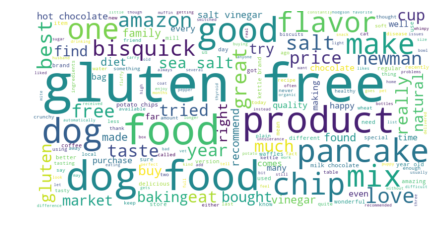

Cluster 0:


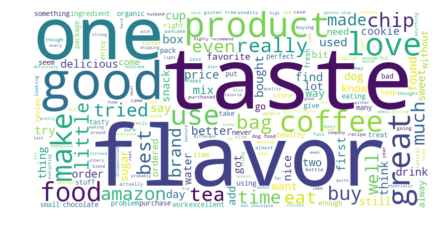

In [316]:
word_cloud(-1,labels)
word_cloud(0,labels)

# [6] Conclusions

In [324]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=["Vectorizer","No. of clusters(K)","Inertia"]

x.add_row(['BOW','5','228593.21'])
x.add_row(['TFIDF','10','309340.1'])
x.add_row(['Avg-W2V','4','31585'])
x.add_row(['Tfidf weighted W2V','4','37885'])
print('** Conclusion : Amazon review dataset with different vectorizers using K-Means Clustering\n')
print(x)
################################################
x=PrettyTable()

x.field_names=["Vectorizer","No. of clusters(K)","cluster counts(cluster number:count of records)"]
x.add_row(['Avg-W2V','5','[0:2789,1:1200,2:275,3:529,4:193]'])
x.add_row(['Tfidf weighted W2V','5','[0:2867,1:730,2:246,3:804,4:339]'])
print('** Conclusion : Amazon review dataset with different vectorizers using Agglomerative Herarchical Clustering\n')
print(x)
################################################
x=PrettyTable()

x.field_names=["Vectorizer","No. of clusters(K)","Epsilon Value","Min Points value"]
x.add_row(['Avg-W2V','2','0.7','200'])
x.add_row(['Tfidf weighted W2V','2','0.7','200'])
print('** Conclusion : Amazon review dataset with different vectorizers using DBSCAN Clustering\n')
print(x)
x=PrettyTable()

** Conclusion : Amazon review dataset with different vectorizers using K-Means Clustering

+--------------------+--------------------+-----------+
|     Vectorizer     | No. of clusters(K) |  Inertia  |
+--------------------+--------------------+-----------+
|        BOW         |         5          | 228593.21 |
|       TFIDF        |         10         |  309340.1 |
|      Avg-W2V       |         4          |   31585   |
| Tfidf weighted W2V |         4          |   37885   |
+--------------------+--------------------+-----------+
** Conclusion : Amazon review dataset with different vectorizers using Agglomerative Herarchical Clustering

+--------------------+--------------------+-------------------------------------------------+
|     Vectorizer     | No. of clusters(K) | cluster counts(cluster number:count of records) |
+--------------------+--------------------+-------------------------------------------------+
|      Avg-W2V       |         5          |        [0:2789,1:1200,2:27